In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy.signal as scsig

In [2]:
from data_handling import LaserDataInteractorESRF
import data_processing as processor

In [3]:
# Known measurmeent variables
fs = 6.25* 10**6 #[Hz]
dt = 1/fs #[s]

# Data info
chNo = 1
fileNo = 19
path_rel = '/Volumes/Sandisk_SD/Work/IZFP/Laser/03_ESRF/Code/measurements/ESRF_TU_Ilmenau_IZFP/Messdaten_QASS'

In [4]:
interactor = LaserDataInteractorESRF()
interactor.path_rel = path_rel
# Ch.1
interactor.fname = (1, fileNo) # ChNo, fileNo
sig1, dt1 = interactor.load_data(ret_dt=True)
sig1 -= sig1.mean()
# Ch.2
interactor.fname = (2, fileNo) # ChNo, fileNo
sig2, dt2 = interactor.load_data(ret_dt=True)
sig2 -= sig2.mean()

print(f'dt={dt*10**6}, dt1={dt*10**6}, dt2={dt2*10**6}')
del dt1, dt2

dt=0.16, dt1=0.16, dt2=0.15999220800524933


In [5]:
#======== Bello functions
#--- window duration
T = 0.5*10**-3 #[s]

def array_fomatting(_sig, _dt, _T):
    # Necessary parameters
    N = len(_sig) # signal length in samples
    L = int(_T/_dt) # window length in samples
    # Zero-padding the signal
    N_new = int(np.ceil(N*_dt/_T)*L) # the target shape, i.e shape AFTER padding
    sig_padded = np.pad(_sig, pad_width=[0, N_new-N], mode='constant', constant_values=0.0)
    print(f'was={N}, is={len(sig_padded)}')
    # Reshape
    data_arr = np.reshape(sig_padded, (L, int(N_new/L)), order='F')
    return sig_padded, data_arr


sig_padded, data_arr = array_fomatting(sig1, dt, T)

#bello1 = np.reshape(data, 


was=5852160, is=5853125


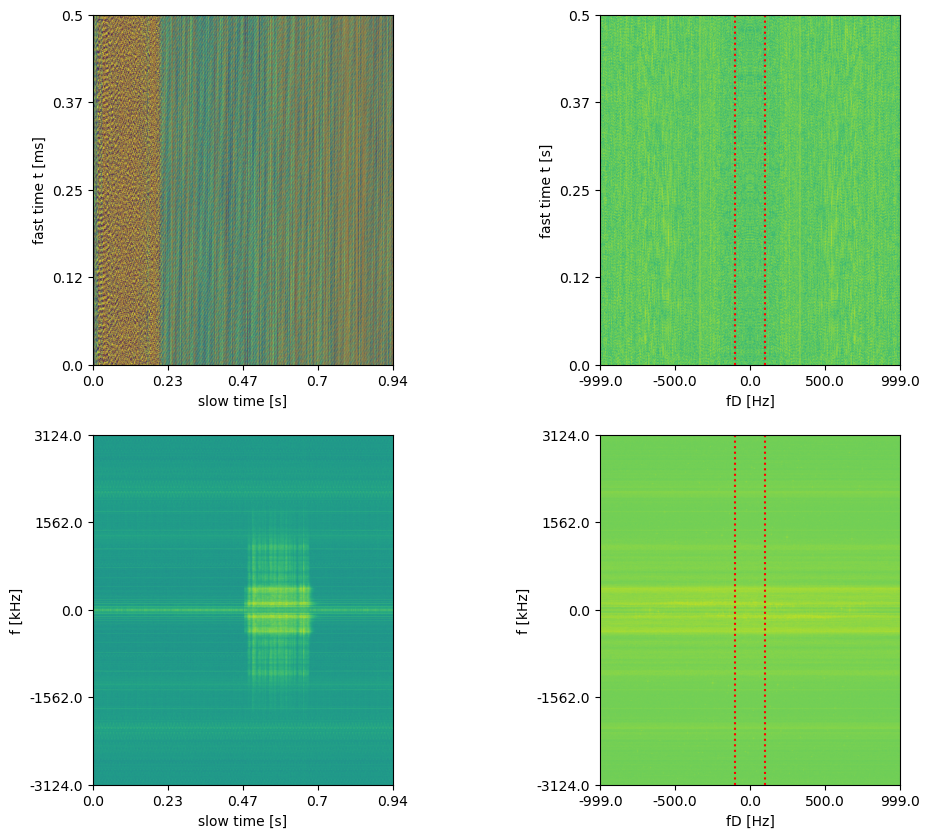

In [9]:
%matplotlib inline
#%matplotlib widget

# Axis setup
tfast_axis = 10**3* dt* np.arange(data_arr.shape[0]) #[ms]
f_axis = 10**-3* fs* np.fft.fftshift(np.fft.fftfreq(data_arr.shape[0])) #[kHz]
tslow_axis = T* np.arange(data_arr.shape[1]) #[s]
fd_axis = (1/T)* np.fft.fftshift(np.fft.fftfreq(data_arr.shape[1])) #[Hz]
x_steps = int(len(tslow_axis)/4)
y_steps = int(len(tfast_axis)/4)
aspect=0.7

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# (1) Time varying CIR
# fast time (in y) vs slow time (in x) 
th_clip = np.quantile(np.abs(sig1), q=0.6)
axs[0, 0].imshow(data_arr, origin='lower', vmin=-th_clip, vmax=th_clip, aspect=aspect)#, cmap='gray'))
# x-axis
axs[0, 0].set_xlabel(f'slow time [s]')
axs[0, 0].set_xticks(x_steps* np.arange(5))
axs[0, 0].set_xticklabels(np.around(tslow_axis[0::x_steps], 2))
#y-axis
axs[0, 0].set_ylabel('fast time t [ms]')
axs[0, 0].set_yticks(y_steps* np.arange(5))
axs[0, 0].set_yticklabels(np.around(tfast_axis[0::y_steps], 2))

# (2) Delay-Doppler
# fast time (in y) vs fd (in x)
H_taufd = np.fft.fftshift(np.fft.fft(data_arr, axis=1))
axs[0, 1].imshow(np.log10(np.abs(H_taufd)), origin='lower', aspect=aspect)#, cmap='gray')
# add fD = 100 Hz lines
x1 = np.where(fd_axis > -100.0)[0][0]
x2 = np.where(fd_axis > 100.0)[0][0]
axs[0, 1].vlines(x = [x1, x2], ymin=0, ymax=H_taufd.shape[0]-1, colors='r', linestyles='dotted')
# x-axis
axs[0, 1].set_xlabel('fD [Hz]')
axs[0, 1].set_xticks(x_steps* np.arange(5))
axs[0, 1].set_xticklabels(np.around(fd_axis[0::x_steps]))
# y-axis
axs[0, 1].set_ylabel('fast time t [s]')
axs[0, 1].set_yticks(y_steps* np.arange(5))
axs[0, 1].set_yticklabels(np.around(tfast_axis[0::y_steps], 2))

# (3) Time varying transfer fct
# f (in y) vs slow time (in x)
H_ft = np.fft.fftshift(np.fft.fft(data_arr, axis=0))
axs[1, 0].imshow(np.log10(np.abs(H_ft)), origin='lower', aspect=aspect)#, cmap='gray')
# x-axis
axs[1, 0].set_xlabel(f'slow time [s]')
axs[1, 0].set_xticks(x_steps* np.arange(5))
axs[1, 0].set_xticklabels(np.around(tslow_axis[0::x_steps], 2))
# y-axis
axs[1, 0].set_ylabel('f [kHz]')
axs[1, 0].set_yticks(y_steps* np.arange(5))
axs[1, 0].set_yticklabels(np.around(f_axis[0::y_steps], 2))


# (4) Freq. Doppler-Spared
# f (in y) vs fd (in x)
H_ffd = np.fft.fftshift(np.fft.fft(H_taufd, axis=0))
axs[1, 1].imshow(np.log10(np.abs(H_ffd)), origin='lower', aspect=aspect)#, cmap='gray')
# add fD = 100 Hz lines
axs[1, 1].vlines(x = [x1, x2], ymin=0, ymax=H_taufd.shape[0]-1, colors='r', linestyles='dotted')
# x-axis
axs[1, 1].set_xlabel('fD [Hz]')
axs[1, 1].set_xticks(x_steps* np.arange(5))
axs[1, 1].set_xticklabels(np.around(fd_axis[0::x_steps]))
# y-axis
axs[1, 1].set_ylabel('f [kHz]')
axs[1, 1].set_yticks(y_steps* np.arange(5))
axs[1, 1].set_yticklabels(np.around(f_axis[0::y_steps], 2))


plt.show()

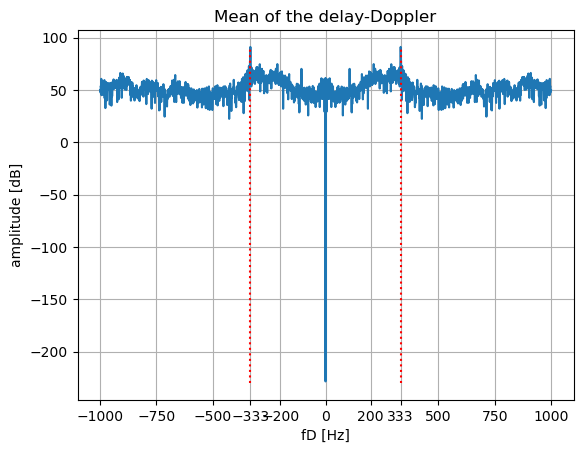

In [35]:
%matplotlib inline
plt.plot(fd_axis, 20*np.log10(np.abs(np.mean(H_taufd, axis=0))))
plt.vlines(x=[-333.0, 333.0], ymin=-20*11.5, ymax=20*4.5, linestyles='dotted', colors='r')
plt.xticks([-1000, -750, -500, -333, -200, 0, 200, 333, 500, 750, 1000])
plt.grid(True)
plt.title('Mean of the delay-Doppler')
plt.xlabel('fD [Hz]')
plt.ylabel('amplitude [dB]')
plt.show()

0.003003003003003003